<a href="https://colab.research.google.com/github/matusoff/ML_models/blob/main/ImageAnalysis_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset: https://www.kaggle.com/competitions/facial-keypoints-detection/overview

credit @wandb

In [7]:
!pip install wandb


import os
import time
import pathlib


import pandas as pd
import numpy as np


# Progress Bar
from tqdm.notebook import tqdm


# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline


# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
# import tensorflow_model_optimization as tfmot


# wandb
import wandb
from wandb.keras import WandbCallback


wandb.login()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.8/258.8 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [8]:
class config:
  DIRECTORY_PATH = "/content/sample_data"
  TRAIN_FILE_PATH = DIRECTORY_PATH + "/training.csv"
  TEST_FILE_PATH = DIRECTORY_PATH + "/test.csv"
  ID_LOOKUP_TABLE_PATH =  DIRECTORY_PATH + "/IdLookupTable.csv"
  SAMPLE_FILE_PATH = DIRECTORY_PATH + "/SampleSubmission.csv"
  SUBMISSION_FILE_PATH = DIRECTORY_PATH + "/outputs/submission.csv"


  BASELINE_CHECKPOINT_PATH = DIRECTORY_PATH + "/models/resnet50_baseline/checkpoint.ckpt"
  POST_TRAINING_QUANTIZATION_PATH = DIRECTORY_PATH + "/models/post_training_quantization/resnet50_quant.tflite"


  VALIDATION_DATA_SIZE = 0.2


  BATCH_SIZE = 32
  NUM_EPOCHS = 150
  LEARNING_RATE = 0.03


## Load Data

In [9]:
def load_data():


  """
  Function to load the train and test dataset
  """


  X_train = pd.read_csv(config.TRAIN_FILE_PATH)
  X_test_original = pd.read_csv(config.TEST_FILE_PATH)


  return X_train, X_test_original


## Check Missing Values

In [10]:
def remove_missing_values():


  """
  Function to drop the samples with missing values
  """


  X_train, X_test_original = load_data()


  X_train = X_train.dropna()
  y_train = X_train.drop(['Image'], axis=1)


  return X_train, y_train, X_test_original


## Check Images

In [11]:
def get_images():


  """
  Function to get correct images format from the data
  """


  X_train, y_train, X_test_original = remove_missing_values()


  # Train Data
  X_train = X_train.Image
  X_train = X_train.apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape((96,96)))


  # Test Data
  X_test_original = X_test_original.Image
  X_test_original = X_test_original.apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape((96,96)))


  X_train /= 255.0
  X_test_original /= 255.0


  return X_train, y_train, X_test_original


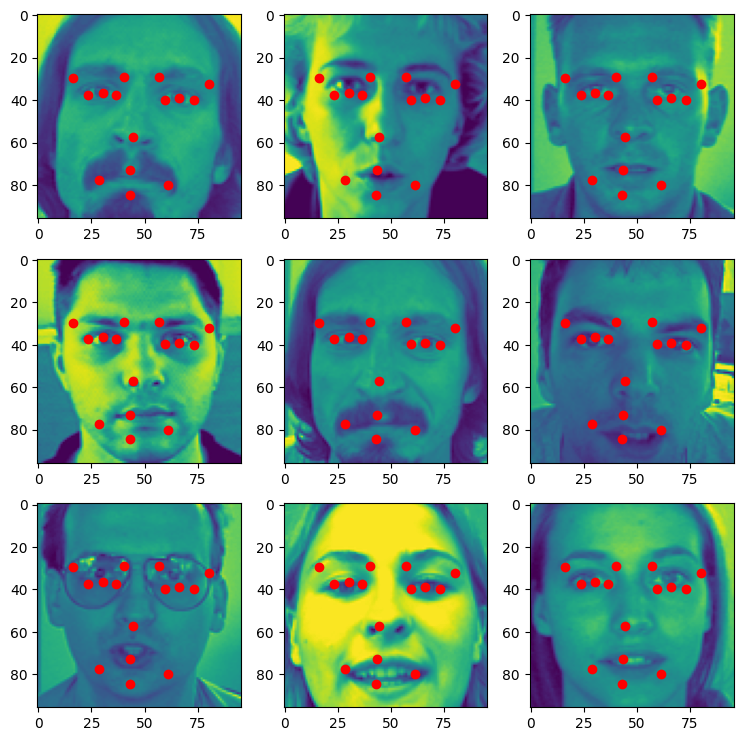

In [12]:
# View Images with their keypoints


X_train, y_train, _ = get_images()


fig = plt.figure(figsize=(9, 9))


for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    plt.imshow(X_train[i])
    for i in range(1, 31, 2):
        plt.plot(y_train.loc[0][i-1], y_train.loc[0][i], 'ro')


plt.show()


each image has 15 keypoints represented by the dots for different locations of their face. The location (x and y coordinates of pixel values) is what we are trying to predict.

## Prepare the Data

In [13]:
def process_data():


  """
  Function to convert, flatten and reshape the arrays
  """


  X_train, y_train, X_test_original = get_images()


  # Convert to arrays
  X_train = X_train.to_numpy()
  X_test_original = X_test_original.to_numpy()


  # Flatten the arrays
  X_train = X_train.flatten()
  X_test_original = X_test_original.flatten()


  X_train = np.concatenate(X_train, axis=0)
  X_train = np.concatenate(X_train, axis=0)


  X_test_original = np.concatenate(X_test_original, axis=0)
  X_test_original = np.concatenate(X_test_original, axis=0)


  # Reshape the arrays to get correct image dimensions
  X_train = X_train.reshape((-1, 96, 96))
  X_test_original = X_test_original.reshape((-1, 96, 96))


  return X_train, y_train, X_test_original


In [14]:
# Obtain Training and Validation Data Splits


def get_data_split():


  """
  Function to obtain train and validation data splits
  """


  X_train, y_train, X_test_original = process_data()


  X_train, X_valid, y_train, y_valid = train_test_split(
      X_train,
      y_train,
      test_size=config.VALIDATION_DATA_SIZE,
      random_state=0
      )


  X_valid, X_test, y_valid, y_test = train_test_split(
      X_valid,
      y_valid,
      test_size=config.VALIDATION_DATA_SIZE,
      random_state=0
      )

  return X_train, X_valid, X_test, y_train, y_valid, y_test


After we have prepared the training, validation and test datasets, we will make the images as 3 channels (originally they are 1 channel only) to suit our requirements which is achieved using the get_correct_dimensions() function.

In [15]:
def get_correct_dimensions():


  """
  Function to convert the data into 3 channels
  """


  X_train, X_valid, X_test, y_train, y_valid, y_test = get_data_split()


  # Reshape all arrays
  X_train = X_train.reshape((-1, 96, 96, 1))
  X_valid = X_valid.reshape((-1, 96, 96, 1))
  X_test = X_test.reshape((-1, 96, 96, 1))


  # Concatenate the data with itself to obtain 3 Channels


  X_train = np.concatenate((X_train, X_train, X_train), axis=-1)
  X_test = np.concatenate((X_test, X_test, X_test), axis=-1)
  X_valid = np.concatenate((X_valid, X_valid, X_valid), axis=-1)


  return X_train, X_test, X_valid, y_train, y_valid, y_test


## ResNet50 Baseline Model
For training the model, we will implement Transfer Learning using a pretrained ResNet50 model. You can try out larger models like EfficientNets too, but for our use case a single ResNet model is enough to achieve a decent score.



In [47]:
def get_callbacks(checkpoint_path, callbacks = tf.keras.callbacks):


  """
  Function to declare the callbacks
  """


  early_stopping = callbacks.EarlyStopping(
      min_delta=0.1, # minimium amount of change to count as an improvement
      patience=20, # how many epochs to wait before stopping
      restore_best_weights=True,
  )


  # Create a callback that saves the model's weights
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_path,
      save_weights_only=True,
      )


  # Define the callbacks
  callbacks = [
      keras.callbacks.TensorBoard(log_dir='./logs'),
      early_stopping,
      checkpoint_callback,
      WandbCallback()
  ]


  return callbacks


Then we define our ResNet model with pretrained weights. However, we will not use all the trainable layers and will add from our side as well.

In [17]:
def get_custom_resnet():


  """
  Function to load pretrained resnet model and freeze certain layers
  """


  inputs = keras.Input(shape=(96, 96, 3))


  # Define the ResNet50 model with pretrained weights (Transfer Learning)
  res_model = ResNet50(
      input_tensor=inputs,
      weights='imagenet'
      )


  # We will only use certain layers, rest we shall define
  for layer in res_model.layers[:143]:
      layer.trainable = False


  return res_model


Finally we define the entire architecture consisting of 3 simple data augmentations, followed by the ResNet model, a flatten layer and a dense layer.

In [18]:
# Final Architecture with Data Augmentations
def setup_model():


  """
  Function to define the final model architecture with data augmentations
  """


  res_model = get_custom_resnet()


  model = keras.models.Sequential()
  model.add(keras.layers.RandomRotation(factor = 0.5))
  model.add(keras.layers.RandomFlip())
  model.add(keras.layers.RandomContrast(factor = 0.5))
  model.add(res_model)
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(30, activation='relu'))


  return model


def setup_pretrained_model(checkpoint_path):


  """
  Function to load pretrained model
  """


  model = make_model()
  model.load_weights(checkpoint_path)


  return model


Now we define the optimizer which in our case is **Adam** and compile the model for training.

**Root Mean Squared Error** is used as the metric.

In [19]:
def make_model():


  """
  Function to load model, define optimizer and compile the model
  """


  model = setup_model()
  # Define Optimizer
  optimizer = keras.optimizers.Adam(learning_rate=config.LEARNING_RATE)


  # Compile the model
  model.compile(
  optimizer=optimizer,
  loss='mean_squared_error',
  metrics=tf.keras.metrics.RootMeanSquaredError()
  )


  return model


 load our datasets, obtain the callbacks and set the model training function.

In [20]:
def run_model(checkpoint_path):


  """
  Function to fit the model on the dataset and report the training time
  """


  X_train, X_test, X_valid, y_train, y_valid, y_test = get_correct_dimensions()


  model = make_model()


  callbacks = get_callbacks(checkpoint_path = checkpoint_path)


  # Train model and save history


  start = time.time()


  history = model.fit(
      X_train,
      y_train,
      validation_data=(X_valid, y_valid),
      batch_size=config.BATCH_SIZE,
      epochs=config.NUM_EPOCHS,
      callbacks=callbacks
      )


  end = time.time()


  print(f"Total Time taken for Model Training: {end - start} seconds.")


  return history


## Run Model

In [21]:
run = wandb.init(project='Post Training Quantization')


history = run_model(config.BASELINE_CHECKPOINT_PATH)


wandb.finish()


wandb: Currently logged in as: osmatusovsky. Use `wandb login --relogin` to force relogin


102967424/102967424 [==============================] - 1s 0us/step


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/150
54/54 [==============================] - ETA: 0s - loss: 2472.9053 - root_mean_squared_error: 49.7283

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 3.6s


54/54 [==============================] - 170s 3s/step - loss: 2472.9053 - root_mean_squared_error: 49.7283 - val_loss: 2434.7627 - val_root_mean_squared_error: 49.3433
Epoch 2/150
54/54 [==============================] - ETA: 0s - loss: 2187.3540 - root_mean_squared_error: 46.7692

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 4.2s


54/54 [==============================] - 167s 3s/step - loss: 2187.3540 - root_mean_squared_error: 46.7692 - val_loss: 2294.6487 - val_root_mean_squared_error: 47.9025
Epoch 3/150
54/54 [==============================] - ETA: 0s - loss: 1932.6526 - root_mean_squared_error: 43.9619

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 4.2s


54/54 [==============================] - 150s 3s/step - loss: 1932.6526 - root_mean_squared_error: 43.9619 - val_loss: 1807.2198 - val_root_mean_squared_error: 42.5114
Epoch 4/150
54/54 [==============================] - ETA: 0s - loss: 1705.4834 - root_mean_squared_error: 41.2975

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 4.3s


54/54 [==============================] - 151s 3s/step - loss: 1705.4834 - root_mean_squared_error: 41.2975 - val_loss: 1593.5243 - val_root_mean_squared_error: 39.9190
Epoch 5/150
54/54 [==============================] - ETA: 0s - loss: 1503.0321 - root_mean_squared_error: 38.7690

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 1.3s


54/54 [==============================] - 162s 3s/step - loss: 1503.0321 - root_mean_squared_error: 38.7690 - val_loss: 1403.1692 - val_root_mean_squared_error: 37.4589
Epoch 6/150
54/54 [==============================] - ETA: 0s - loss: 1322.8599 - root_mean_squared_error: 36.3711

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 3.6s


54/54 [==============================] - 168s 3s/step - loss: 1322.8599 - root_mean_squared_error: 36.3711 - val_loss: 1234.0551 - val_root_mean_squared_error: 35.1291
Epoch 7/150
54/54 [==============================] - ETA: 0s - loss: 1162.8540 - root_mean_squared_error: 34.1006

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 2.0s


54/54 [==============================] - 151s 3s/step - loss: 1162.8540 - root_mean_squared_error: 34.1006 - val_loss: 1083.8981 - val_root_mean_squared_error: 32.9226
Epoch 8/150
54/54 [==============================] - ETA: 0s - loss: 1020.9496 - root_mean_squared_error: 31.9523

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 3.5s


54/54 [==============================] - 161s 3s/step - loss: 1020.9496 - root_mean_squared_error: 31.9523 - val_loss: 950.9034 - val_root_mean_squared_error: 30.8367
Epoch 9/150
54/54 [==============================] - ETA: 0s - loss: 895.2870 - root_mean_squared_error: 29.9213

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 3.0s


54/54 [==============================] - 168s 3s/step - loss: 895.2870 - root_mean_squared_error: 29.9213 - val_loss: 833.2850 - val_root_mean_squared_error: 28.8667
Epoch 10/150
54/54 [==============================] - ETA: 0s - loss: 784.2114 - root_mean_squared_error: 28.0038

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 3.7s


54/54 [==============================] - 163s 3s/step - loss: 784.2114 - root_mean_squared_error: 28.0038 - val_loss: 729.2812 - val_root_mean_squared_error: 27.0052
Epoch 11/150
54/54 [==============================] - ETA: 0s - loss: 686.1142 - root_mean_squared_error: 26.1938

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 1.3s


54/54 [==============================] - 152s 3s/step - loss: 686.1142 - root_mean_squared_error: 26.1938 - val_loss: 637.6020 - val_root_mean_squared_error: 25.2508
Epoch 12/150
54/54 [==============================] - ETA: 0s - loss: 599.6099 - root_mean_squared_error: 24.4869

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 1.1s


54/54 [==============================] - 153s 3s/step - loss: 599.6099 - root_mean_squared_error: 24.4869 - val_loss: 556.7468 - val_root_mean_squared_error: 23.5955
Epoch 13/150
54/54 [==============================] - ETA: 0s - loss: 523.3683 - root_mean_squared_error: 22.8772

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 1.4s


54/54 [==============================] - 162s 3s/step - loss: 523.3683 - root_mean_squared_error: 22.8772 - val_loss: 485.5713 - val_root_mean_squared_error: 22.0357
Epoch 14/150
54/54 [==============================] - ETA: 0s - loss: 456.2361 - root_mean_squared_error: 21.3597

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 2.2s


54/54 [==============================] - 162s 3s/step - loss: 456.2361 - root_mean_squared_error: 21.3597 - val_loss: 422.9074 - val_root_mean_squared_error: 20.5647
Epoch 15/150
54/54 [==============================] - ETA: 0s - loss: 397.1804 - root_mean_squared_error: 19.9294

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 1.4s


54/54 [==============================] - 155s 3s/step - loss: 397.1804 - root_mean_squared_error: 19.9294 - val_loss: 367.8272 - val_root_mean_squared_error: 19.1788
Epoch 16/150
54/54 [==============================] - ETA: 0s - loss: 345.2883 - root_mean_squared_error: 18.5819

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 3.9s


54/54 [==============================] - 154s 3s/step - loss: 345.2883 - root_mean_squared_error: 18.5819 - val_loss: 319.4507 - val_root_mean_squared_error: 17.8732
Epoch 17/150
54/54 [==============================] - ETA: 0s - loss: 299.7236 - root_mean_squared_error: 17.3125

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 4.2s


54/54 [==============================] - 172s 3s/step - loss: 299.7236 - root_mean_squared_error: 17.3125 - val_loss: 277.0424 - val_root_mean_squared_error: 16.6446
Epoch 18/150
54/54 [==============================] - ETA: 0s - loss: 259.7651 - root_mean_squared_error: 16.1172

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 3.7s


54/54 [==============================] - 151s 3s/step - loss: 259.7651 - root_mean_squared_error: 16.1172 - val_loss: 239.8383 - val_root_mean_squared_error: 15.4867
Epoch 19/150
54/54 [==============================] - ETA: 0s - loss: 224.7618 - root_mean_squared_error: 14.9921

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 1.1s


54/54 [==============================] - 150s 3s/step - loss: 224.7618 - root_mean_squared_error: 14.9921 - val_loss: 207.3334 - val_root_mean_squared_error: 14.3991
Epoch 20/150
54/54 [==============================] - ETA: 0s - loss: 194.1772 - root_mean_squared_error: 13.9347

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 4.8s


54/54 [==============================] - 152s 3s/step - loss: 194.1772 - root_mean_squared_error: 13.9347 - val_loss: 178.9145 - val_root_mean_squared_error: 13.3759
Epoch 21/150
54/54 [==============================] - ETA: 0s - loss: 167.4859 - root_mean_squared_error: 12.9416

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 3.2s


54/54 [==============================] - 160s 3s/step - loss: 167.4859 - root_mean_squared_error: 12.9416 - val_loss: 154.1454 - val_root_mean_squared_error: 12.4155
Epoch 22/150
54/54 [==============================] - ETA: 0s - loss: 144.2387 - root_mean_squared_error: 12.0099

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 2.8s


54/54 [==============================] - 150s 3s/step - loss: 144.2387 - root_mean_squared_error: 12.0099 - val_loss: 132.6348 - val_root_mean_squared_error: 11.5167
Epoch 23/150
54/54 [==============================] - ETA: 0s - loss: 124.0543 - root_mean_squared_error: 11.1380

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 3.9s


54/54 [==============================] - 151s 3s/step - loss: 124.0543 - root_mean_squared_error: 11.1380 - val_loss: 113.9723 - val_root_mean_squared_error: 10.6758
Epoch 24/150
54/54 [==============================] - ETA: 0s - loss: 106.5585 - root_mean_squared_error: 10.3227

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 3.7s


54/54 [==============================] - 167s 3s/step - loss: 106.5585 - root_mean_squared_error: 10.3227 - val_loss: 97.8086 - val_root_mean_squared_error: 9.8898
Epoch 25/150
54/54 [==============================] - ETA: 0s - loss: 91.4389 - root_mean_squared_error: 9.5624

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 1.1s


54/54 [==============================] - 156s 3s/step - loss: 91.4389 - root_mean_squared_error: 9.5624 - val_loss: 83.9173 - val_root_mean_squared_error: 9.1606
Epoch 26/150
54/54 [==============================] - ETA: 0s - loss: 78.4349 - root_mean_squared_error: 8.8563

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 3.9s


54/54 [==============================] - 153s 3s/step - loss: 78.4349 - root_mean_squared_error: 8.8563 - val_loss: 71.9254 - val_root_mean_squared_error: 8.4809
Epoch 27/150
54/54 [==============================] - ETA: 0s - loss: 67.2650 - root_mean_squared_error: 8.2015

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 1.1s


54/54 [==============================] - 151s 3s/step - loss: 67.2650 - root_mean_squared_error: 8.2015 - val_loss: 61.7066 - val_root_mean_squared_error: 7.8554
Epoch 28/150
54/54 [==============================] - ETA: 0s - loss: 57.7297 - root_mean_squared_error: 7.5980

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 1.6s


54/54 [==============================] - 167s 3s/step - loss: 57.7297 - root_mean_squared_error: 7.5980 - val_loss: 52.9754 - val_root_mean_squared_error: 7.2784
Epoch 29/150
54/54 [==============================] - ETA: 0s - loss: 49.6079 - root_mean_squared_error: 7.0433

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 1.4s


54/54 [==============================] - 163s 3s/step - loss: 49.6079 - root_mean_squared_error: 7.0433 - val_loss: 45.5664 - val_root_mean_squared_error: 6.7503
Epoch 30/150
54/54 [==============================] - ETA: 0s - loss: 42.7229 - root_mean_squared_error: 6.5363

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 1.7s


54/54 [==============================] - 151s 3s/step - loss: 42.7229 - root_mean_squared_error: 6.5363 - val_loss: 39.2869 - val_root_mean_squared_error: 6.2679
Epoch 31/150
54/54 [==============================] - ETA: 0s - loss: 36.9077 - root_mean_squared_error: 6.0752

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 1.3s


54/54 [==============================] - 151s 3s/step - loss: 36.9077 - root_mean_squared_error: 6.0752 - val_loss: 34.0129 - val_root_mean_squared_error: 5.8321
Epoch 32/150
54/54 [==============================] - ETA: 0s - loss: 32.0237 - root_mean_squared_error: 5.6590

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 1.3s


54/54 [==============================] - 158s 3s/step - loss: 32.0237 - root_mean_squared_error: 5.6590 - val_loss: 29.5981 - val_root_mean_squared_error: 5.4404
Epoch 33/150
54/54 [==============================] - ETA: 0s - loss: 27.9464 - root_mean_squared_error: 5.2864

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 4.0s


54/54 [==============================] - 156s 3s/step - loss: 27.9464 - root_mean_squared_error: 5.2864 - val_loss: 25.9084 - val_root_mean_squared_error: 5.0900
Epoch 34/150
54/54 [==============================] - ETA: 0s - loss: 24.5478 - root_mean_squared_error: 4.9546

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 2.0s


54/54 [==============================] - 150s 3s/step - loss: 24.5478 - root_mean_squared_error: 4.9546 - val_loss: 22.8526 - val_root_mean_squared_error: 4.7804
Epoch 35/150
54/54 [==============================] - ETA: 0s - loss: 21.7333 - root_mean_squared_error: 4.6619

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 4.3s


54/54 [==============================] - 154s 3s/step - loss: 21.7333 - root_mean_squared_error: 4.6619 - val_loss: 20.3365 - val_root_mean_squared_error: 4.5096
Epoch 36/150
54/54 [==============================] - ETA: 0s - loss: 19.4192 - root_mean_squared_error: 4.4067

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 5.0s


54/54 [==============================] - 169s 3s/step - loss: 19.4192 - root_mean_squared_error: 4.4067 - val_loss: 18.2711 - val_root_mean_squared_error: 4.2745
Epoch 37/150
54/54 [==============================] - ETA: 0s - loss: 17.5248 - root_mean_squared_error: 4.1863

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 4.3s


54/54 [==============================] - 156s 3s/step - loss: 17.5248 - root_mean_squared_error: 4.1863 - val_loss: 16.5910 - val_root_mean_squared_error: 4.0732
Epoch 38/150
54/54 [==============================] - ETA: 0s - loss: 15.9849 - root_mean_squared_error: 3.9981

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 1.1s


54/54 [==============================] - 149s 3s/step - loss: 15.9849 - root_mean_squared_error: 3.9981 - val_loss: 15.2205 - val_root_mean_squared_error: 3.9013
Epoch 39/150
54/54 [==============================] - ETA: 0s - loss: 14.7371 - root_mean_squared_error: 3.8389

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 1.1s


54/54 [==============================] - 152s 3s/step - loss: 14.7371 - root_mean_squared_error: 3.8389 - val_loss: 14.1153 - val_root_mean_squared_error: 3.7570
Epoch 40/150
54/54 [==============================] - ETA: 0s - loss: 13.7372 - root_mean_squared_error: 3.7064

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 1.2s


54/54 [==============================] - 159s 3s/step - loss: 13.7372 - root_mean_squared_error: 3.7064 - val_loss: 13.2323 - val_root_mean_squared_error: 3.6376
Epoch 41/150
54/54 [==============================] - ETA: 0s - loss: 12.9369 - root_mean_squared_error: 3.5968

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 1.1s


54/54 [==============================] - 152s 3s/step - loss: 12.9369 - root_mean_squared_error: 3.5968 - val_loss: 12.5400 - val_root_mean_squared_error: 3.5412
Epoch 42/150
54/54 [==============================] - ETA: 0s - loss: 12.3002 - root_mean_squared_error: 3.5072

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 2.0s


54/54 [==============================] - 156s 3s/step - loss: 12.3002 - root_mean_squared_error: 3.5072 - val_loss: 11.9913 - val_root_mean_squared_error: 3.4628
Epoch 43/150
54/54 [==============================] - ETA: 0s - loss: 11.8052 - root_mean_squared_error: 3.4359

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 4.2s


54/54 [==============================] - 156s 3s/step - loss: 11.8052 - root_mean_squared_error: 3.4359 - val_loss: 11.5471 - val_root_mean_squared_error: 3.3981
Epoch 44/150
54/54 [==============================] - ETA: 0s - loss: 11.4114 - root_mean_squared_error: 3.3781

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 4.8s


54/54 [==============================] - 163s 3s/step - loss: 11.4114 - root_mean_squared_error: 3.3781 - val_loss: 11.2174 - val_root_mean_squared_error: 3.3492
Epoch 45/150
54/54 [==============================] - ETA: 0s - loss: 11.1093 - root_mean_squared_error: 3.3331

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 3.6s


54/54 [==============================] - 153s 3s/step - loss: 11.1093 - root_mean_squared_error: 3.3331 - val_loss: 10.9563 - val_root_mean_squared_error: 3.3100
Epoch 46/150
54/54 [==============================] - ETA: 0s - loss: 10.8755 - root_mean_squared_error: 3.2978

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 2.4s


54/54 [==============================] - 163s 3s/step - loss: 10.8755 - root_mean_squared_error: 3.2978 - val_loss: 10.7543 - val_root_mean_squared_error: 3.2794
Epoch 47/150
54/54 [==============================] - ETA: 0s - loss: 10.6967 - root_mean_squared_error: 3.2706

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 3.0s


54/54 [==============================] - 155s 3s/step - loss: 10.6967 - root_mean_squared_error: 3.2706 - val_loss: 10.6044 - val_root_mean_squared_error: 3.2564
Epoch 48/150
54/54 [==============================] - ETA: 0s - loss: 10.5617 - root_mean_squared_error: 3.2499

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 3.3s


54/54 [==============================] - 163s 3s/step - loss: 10.5617 - root_mean_squared_error: 3.2499 - val_loss: 10.4864 - val_root_mean_squared_error: 3.2383
Epoch 49/150
54/54 [==============================] - ETA: 0s - loss: 10.4602 - root_mean_squared_error: 3.2342

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 4.1s


54/54 [==============================] - 164s 3s/step - loss: 10.4602 - root_mean_squared_error: 3.2342 - val_loss: 10.4021 - val_root_mean_squared_error: 3.2252
Epoch 50/150
54/54 [==============================] - ETA: 0s - loss: 10.3829 - root_mean_squared_error: 3.2223

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 3.1s


54/54 [==============================] - 157s 3s/step - loss: 10.3829 - root_mean_squared_error: 3.2223 - val_loss: 10.3375 - val_root_mean_squared_error: 3.2152
Epoch 51/150
54/54 [==============================] - ETA: 0s - loss: 10.3273 - root_mean_squared_error: 3.2136

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 1.1s


54/54 [==============================] - 180s 3s/step - loss: 10.3273 - root_mean_squared_error: 3.2136 - val_loss: 10.2932 - val_root_mean_squared_error: 3.2083
Epoch 52/150
54/54 [==============================] - ETA: 0s - loss: 10.2854 - root_mean_squared_error: 3.2071

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 2.7s


54/54 [==============================] - 185s 3s/step - loss: 10.2854 - root_mean_squared_error: 3.2071 - val_loss: 10.2562 - val_root_mean_squared_error: 3.2025
Epoch 53/150
54/54 [==============================] - ETA: 0s - loss: 10.2550 - root_mean_squared_error: 3.2023

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 3.0s


54/54 [==============================] - 155s 3s/step - loss: 10.2550 - root_mean_squared_error: 3.2023 - val_loss: 10.2315 - val_root_mean_squared_error: 3.1987
Epoch 54/150
54/54 [==============================] - ETA: 0s - loss: 10.2342 - root_mean_squared_error: 3.1991

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 4.7s


54/54 [==============================] - 158s 3s/step - loss: 10.2342 - root_mean_squared_error: 3.1991 - val_loss: 10.2142 - val_root_mean_squared_error: 3.1960
Epoch 55/150
54/54 [==============================] - ETA: 0s - loss: 10.2184 - root_mean_squared_error: 3.1966

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 3.2s


54/54 [==============================] - 166s 3s/step - loss: 10.2184 - root_mean_squared_error: 3.1966 - val_loss: 10.2016 - val_root_mean_squared_error: 3.1940
Epoch 56/150
54/54 [==============================] - ETA: 0s - loss: 10.2078 - root_mean_squared_error: 3.1950

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 2.1s


54/54 [==============================] - 152s 3s/step - loss: 10.2078 - root_mean_squared_error: 3.1950 - val_loss: 10.1921 - val_root_mean_squared_error: 3.1925
Epoch 57/150
54/54 [==============================] - ETA: 0s - loss: 10.2000 - root_mean_squared_error: 3.1937

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 1.0s


54/54 [==============================] - 160s 3s/step - loss: 10.2000 - root_mean_squared_error: 3.1937 - val_loss: 10.1856 - val_root_mean_squared_error: 3.1915
Epoch 58/150
54/54 [==============================] - ETA: 0s - loss: 10.1941 - root_mean_squared_error: 3.1928

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 1.1s


54/54 [==============================] - 161s 3s/step - loss: 10.1941 - root_mean_squared_error: 3.1928 - val_loss: 10.1812 - val_root_mean_squared_error: 3.1908
Epoch 59/150
54/54 [==============================] - ETA: 0s - loss: 10.1921 - root_mean_squared_error: 3.1925

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 1.2s


54/54 [==============================] - 172s 3s/step - loss: 10.1921 - root_mean_squared_error: 3.1925 - val_loss: 10.1779 - val_root_mean_squared_error: 3.1903
Epoch 60/150
54/54 [==============================] - ETA: 0s - loss: 10.1894 - root_mean_squared_error: 3.1921

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 4.1s


54/54 [==============================] - 163s 3s/step - loss: 10.1894 - root_mean_squared_error: 3.1921 - val_loss: 10.1761 - val_root_mean_squared_error: 3.1900
Epoch 61/150
54/54 [==============================] - ETA: 0s - loss: 10.1888 - root_mean_squared_error: 3.1920

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 1.9s


54/54 [==============================] - 151s 3s/step - loss: 10.1888 - root_mean_squared_error: 3.1920 - val_loss: 10.1741 - val_root_mean_squared_error: 3.1897
Epoch 62/150
54/54 [==============================] - ETA: 0s - loss: 10.1857 - root_mean_squared_error: 3.1915

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 1.5s


54/54 [==============================] - 166s 3s/step - loss: 10.1857 - root_mean_squared_error: 3.1915 - val_loss: 10.1726 - val_root_mean_squared_error: 3.1894
Epoch 63/150
54/54 [==============================] - ETA: 0s - loss: 10.1855 - root_mean_squared_error: 3.1915

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 3.5s


54/54 [==============================] - 165s 3s/step - loss: 10.1855 - root_mean_squared_error: 3.1915 - val_loss: 10.1715 - val_root_mean_squared_error: 3.1893
Epoch 64/150
54/54 [==============================] - ETA: 0s - loss: 10.1854 - root_mean_squared_error: 3.1915

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 1.3s


54/54 [==============================] - 151s 3s/step - loss: 10.1854 - root_mean_squared_error: 3.1915 - val_loss: 10.1709 - val_root_mean_squared_error: 3.1892
Epoch 65/150
54/54 [==============================] - 132s 2s/step - loss: 10.1856 - root_mean_squared_error: 3.1915 - val_loss: 10.1722 - val_root_mean_squared_error: 3.1894
Epoch 66/150
54/54 [==============================] - ETA: 0s - loss: 10.1857 - root_mean_squared_error: 3.1915

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 1.3s


54/54 [==============================] - 151s 3s/step - loss: 10.1857 - root_mean_squared_error: 3.1915 - val_loss: 10.1705 - val_root_mean_squared_error: 3.1891
Epoch 67/150
54/54 [==============================] - 140s 3s/step - loss: 10.1850 - root_mean_squared_error: 3.1914 - val_loss: 10.1709 - val_root_mean_squared_error: 3.1892
Epoch 68/150
54/54 [==============================] - 120s 2s/step - loss: 10.1859 - root_mean_squared_error: 3.1915 - val_loss: 10.1714 - val_root_mean_squared_error: 3.1893
Epoch 69/150
54/54 [==============================] - 122s 2s/step - loss: 10.1854 - root_mean_squared_error: 3.1915 - val_loss: 10.1713 - val_root_mean_squared_error: 3.1892
Epoch 70/150
54/54 [==============================] - ETA: 0s - loss: 10.1861 - root_mean_squared_error: 3.1916

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240309_150853-pelke1oe/files/model-best)... Done. 2.4s


54/54 [==============================] - 154s 3s/step - loss: 10.1861 - root_mean_squared_error: 3.1916 - val_loss: 10.1702 - val_root_mean_squared_error: 3.1891
Epoch 71/150
54/54 [==============================] - 124s 2s/step - loss: 10.1850 - root_mean_squared_error: 3.1914 - val_loss: 10.1713 - val_root_mean_squared_error: 3.1892
Epoch 72/150
54/54 [==============================] - 134s 2s/step - loss: 10.1871 - root_mean_squared_error: 3.1917 - val_loss: 10.1706 - val_root_mean_squared_error: 3.1891
Epoch 73/150
54/54 [==============================] - 125s 2s/step - loss: 10.1849 - root_mean_squared_error: 3.1914 - val_loss: 10.1706 - val_root_mean_squared_error: 3.1891
Total Time taken for Model Training: 11366.465651988983 seconds.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
root_mean_squared_error,██▇▆▅▅▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_root_mean_squared_error,██▇▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,69
best_val_loss,10.17019
epoch,72
loss,10.18489
root_mean_squared_error,3.19138
val_loss,10.1706


## Model Evaluation and Size

In [22]:
def evaluate_model(checkpoint_path):
  """
  Function to calculate loss and root mean squared error on validation dataset
  """


  model = setup_pretrained_model(checkpoint_path)


  _, X_test, _, _, _, y_test = get_correct_dimensions()


  loss, rmse = model.evaluate(X_test, y_test)  # returns loss and metrics
  print("loss: %.2f" % loss)
  print("rmse: %.2f" % rmse)


def get_model_size(path, checkpoint = True):


  """
  Function to obtain the size of a model
  """

  if checkpoint:
    filepath = path + '.data-00000-of-00001'


  else:
    filepath = path

  print(f"{os.path.getsize(filepath)/float(1<<20):,.0f} MB")


In [23]:
# Evaluate Model
evaluate_model(config.BASELINE_CHECKPOINT_PATH)


# Model Size
get_model_size(config.BASELINE_CHECKPOINT_PATH)


3/3 [==============================] - 5s 689ms/step - loss: 9.3641 - root_mean_squared_error: 3.0601
loss: 9.36
rmse: 3.06
228 MB


## Post-Training Quantization
Post-training quantization includes general techniques to reduce CPU and hardware accelerator latency, processing, power, and model size with little degradation in model accuracy.
These techniques can be performed on an already-trained float TensorFlow model and applied during TensorFlow Lite conversion.
These techniques are enabled as options in the TensorFlow Lite converter.
To implement post-training quantization, in Step-1 we first load our fine tuned model and build it with the input size.


In [24]:
# Load Baseline Model
model = setup_pretrained_model(config.BASELINE_CHECKPOINT_PATH)


# Build Model
model.build((None, 96,96,3))


## Convert Model to TensorFlow Lite Format
In Step-2 we convert our fine tuned model to a TensorFlow Lite Model.
This can be easily achieved using the Python TFLiteConverter

In [25]:
# Convert to TensorFlow Lite Model with optimization


converter = tf.lite.TFLiteConverter.from_keras_model(model)	# Define Converter
converter.optimizations = [tf.lite.Optimize.DEFAULT]		# Activate quantization
tflite_quant_model = converter.convert()			# Convert the model


In [26]:
# Path of TFLite Models
dir_path = config.DIRECTORY_PATH + "/models/post_training_quantization/"


tflite_models_dir = pathlib.Path(dir_path)
tflite_models_dir.mkdir(exist_ok=True, parents=True)


tflite_model_quant_file = tflite_models_dir/"resnet50_quant.tflite"


# Write File
tflite_model_quant_file.write_bytes(tflite_quant_model)


26007384

In [27]:
# Model Size
get_model_size(config.POST_TRAINING_QUANTIZATION_PATH, checkpoint = False)


25 MB


The new quantized model size is just 25 MB! We were able to reduce the model size by 10 time just by quantization.

In [28]:
# Obtain datasets
X_train, X_test, X_valid, y_train, y_valid, y_test = get_correct_dimensions()


In [29]:
# Load Model into Interpreter
'''
To run a TensorFlow Lite model we need to use the TensorFlow Lite Interpreter
and load the quantized model into the interpreter.
'''

interpreter = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter.allocate_tensors()


## Evaluate One Image

In [30]:
test_image = X_train[0].astype(np.float32)


input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]


interpreter.set_tensor(input_index, tf.expand_dims(test_image, axis=0))


interpreter.invoke()
predictions = (interpreter.get_tensor(output_index)).flatten()


mean_squared_error(y_test.iloc[0,:].values, predictions, squared = False)


2.162408841063427

## Evaluate on validation dataset

In [31]:
# A helper function to evaluate the TF Lite model using "test" dataset.


def evaluate_quant_model(interpreter):


  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]


  # Run predictions on every image in the validation dataset.
  final_predictions = []
  rmse = 0


  for test_image, target in tqdm(zip(X_test, y_test.values), total = len(X_test)):


    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = test_image.astype(np.float32)
    interpreter.set_tensor(input_index, tf.expand_dims(test_image, axis=0))


    # Run inference.
    interpreter.invoke()


    # Post-processing:
    output = interpreter.tensor(output_index)


    # Obtain Predictions
    predictions = (interpreter.get_tensor(output_index)).flatten()
    final_predictions.append(predictions)


    # Evaluate Model
    rmse += (mean_squared_error(target, predictions, squared = False))/len(X_test)


  return rmse


In [32]:
rmse = evaluate_quant_model(interpreter)


print(rmse)


  0%|          | 0/86 [00:00<?, ?it/s]

2.8501249738009475


## Post-Training Quantization Model Conclusion:
Here are the results from the Quantized Model.
Model Description -
ResNet50 with Pretrained Weights along with Data Augmentations

Post-Training Dynamic Range Quantization


Result -
Root Mean Squared Error = 2.84 (Considerably better than baseline model)

Evaluation Time = 199 seconds

Model Size = 25 MB (10 times smaller than baseline model)




## TFLite Inference
In the final step, we will perform inference on the original Test Dataset provided in the competition. The steps are similar as the last section.


In [33]:
def tflite_inference(interpreter):
  """
  Function to perform inference of a tflite model
  """


  # Prepare Test Dataset
  _, _, X_test_original = process_data()
  X_test_original = X_test_original.reshape((-1, 96, 96, 1))
  X_test_original = np.concatenate((X_test_original, X_test_original, X_test_original), axis=-1)


  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]


  # Run predictions on every image in the validation dataset.
  final_predictions = []


  for test_image in tqdm(X_test_original, total = len(X_test_original)):


    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = test_image.astype(np.float32)
    interpreter.set_tensor(input_index, tf.expand_dims(test_image, axis=0))


    # Run inference.
    interpreter.invoke()


    # Post-processing:
    output = interpreter.tensor(output_index)


    # Obtain Predictions
    predictions = (interpreter.get_tensor(output_index)).flatten()
    final_predictions.append(predictions)


  return final_predictions


In [34]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=config.POST_TRAINING_QUANTIZATION_PATH)
interpreter.allocate_tensors()


predictions = tflite_inference(interpreter)


  0%|          | 0/1783 [00:00<?, ?it/s]

After we have obtained the predictions,
we create a submission file for the competition, which contains the Row Id along with the location of the keypoint.

In [42]:
def generate_submission(predictions):


  """
  Function to create submission file from the model predictions
  """


  # Convert list to array
  predictions = np.array(predictions)


  # Get data
  _, _, _, y_train, _, _ = get_correct_dimensions()
  cols = list(y_train.columns)


  # Load Id LookUp Table
  df = pd.read_csv(config.ID_LOOKUP_TABLE_PATH)


  # Fill the locations
  for i in range(df.shape[0]):
      df.Location[i] = predictions[df.ImageId[i]-1][cols.index(df.FeatureName[i])]


  # Drop Columns which are not required in submission
  df.drop(['ImageId', 'FeatureName'], axis=1, inplace=True)


  # Set Row Id as index
  df = df.set_index(['RowId'])

  # Save submission file
  df.to_csv(config.SUBMISSION_FILE_PATH)


In [43]:
generate_submission(predictions)

<ipython-input-42-467f4424462b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Location[i] = predictions[df.ImageId[i]-1][cols.index(df.FeatureName[i])]


In [45]:
# plot a couple of images from the test set to see how well our model performs.


def plot_test_image(df, prediction, index):
    """
    Function to plot images with their predictions for test set
    """
    image = plt.imshow(df[index])
    l = []

    for i in range(1, 31, 2):
        l.append(plt.plot(prediction[index][i-1], prediction[index][i], 'ro'))

    return image, l


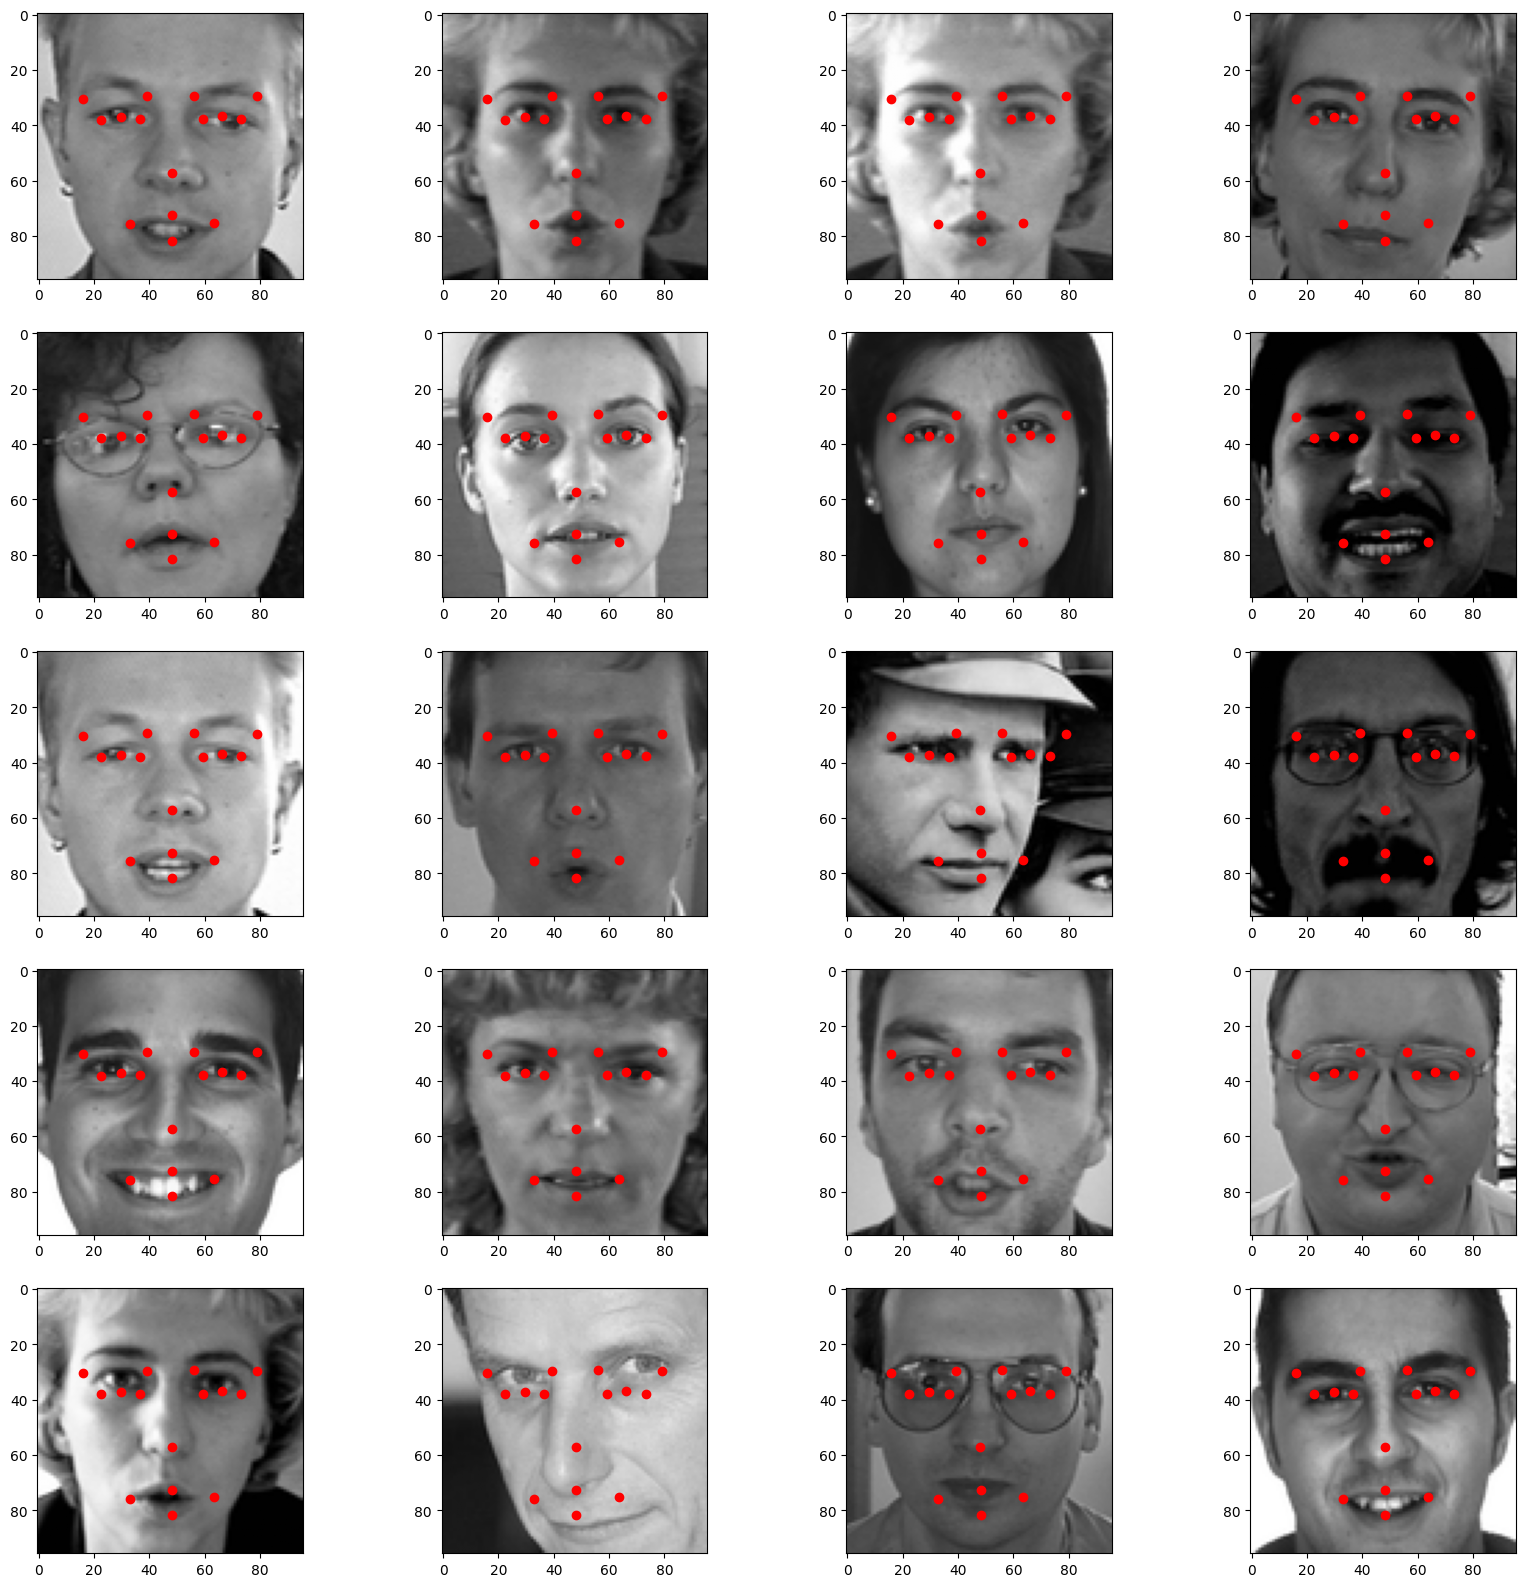

In [46]:
fig = plt.figure(figsize=(20, 20))

for i in range(20):
    ax = fig.add_subplot(5, 4, i + 1)
    plot_test_image(X_test, predictions, i)

plt.show()


After Post-Training Quantization the key features represented by the dots for different locations of the face are improved.